<a href="https://colab.research.google.com/github/madhes23/deep_learning/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.6 MB/s eta 0:00:00


In [16]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math
from enum import Enum
# import wandb
from sklearn.model_selection import train_test_split

# Importing and plotting samples

In [17]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, train_size=0.8)

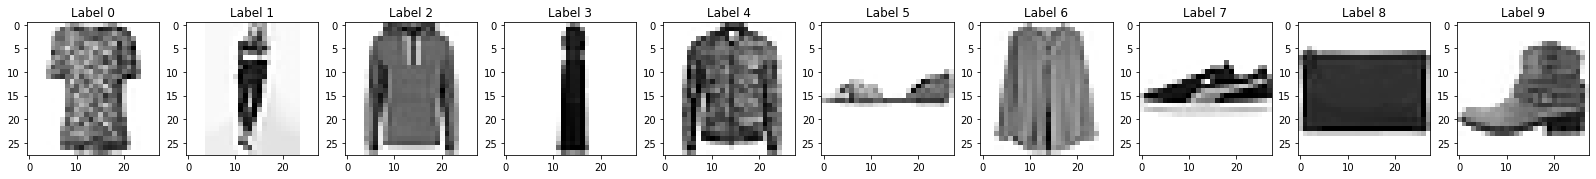

In [18]:
no_of_items = 10

fig, axes = plt.subplots(nrows = 1, ncols=10, figsize = (28, 28))
for item in range(no_of_items):
  index = 0
  while(y_train[index] != item): #searching for the first occurance of the element
    index = index+1
  
  ax = axes[item]
  ax.imshow(x_train[index], cmap='gray_r')
  ax.set_title('Label {}'.format(item))

# Reshaping the data for nerual network


In [19]:
no_of_pixels = x_train[0].size
x_train = x_train.reshape(-1, no_of_pixels)/255
x_test = x_test.reshape(-1, no_of_pixels)/255
x_validation = x_validation.reshape(-1, no_of_pixels)/255

# Some Utility functions

In [20]:
class ActivationFunction(Enum):
  SIGMOID = "sigmoid"
  RELU = "relu"
  TAN_H = "tanh"

class InitializationMethod(Enum):
  UNIFORM_RANDOM = "uniform_rand"
  UNIFORM_XAVIER = "uniform_xav"
  GAUSSIAN_XAVIER = "gaussian_xav"

class OutputFunction(Enum):
  SOFTMAX = "softmax"

class OptimizationAlgorithm(Enum):
  GD = "gd"
  SGD = "sgd"
  MINI_BATCH = "mini_batch"
  MOMENTUM_GD = "momentum_gd"
  NAG = "nag"
  RMS_PROP = "rms"
  ADAM = "adam"
  NADAM = "nadam"

class ErrorCalculationMethod(Enum):
  CROSS_ENTROPY = "cross_entropy"
  MEAN_SQUARE_ERROR = "mse"


def activation_function(a, func):
  """
  Calculates post activation values from pre-activation values, functions implemented:
  * Sigmoid
  * ReLU
  * Tan h

  Parameters:
  -----------
  a: ndarray, pre-activation values
  func: Enum describing the activation function type

  Retruns:
  -------
  Post activation values in ndarray of the same dimention
  """
  if(func == ActivationFunction.SIGMOID):   
    # clipping_limit = 400
    # return 1.0 / (1.0 + np.exp(-np.clip(a,-clipping_limit,clipping_limit)))
    new = a.copy()
    new[a<0] = np.exp(a[a<0])/(1.0 + np.exp(a[a<0]))
    new[a>=0] = 1/(1+np.exp(-a[a>=0]))
    return new

  if(func == ActivationFunction.RELU):
    return np.maximum(0,a)

  if(func == ActivationFunction.TAN_H):
    e_pow_a = np.exp(a)
    e_pow_neg_a = np.exp(-a)
    return (e_pow_a - e_pow_neg_a)/(e_pow_a + e_pow_neg_a)


def df_activation_function(a, func):
  """
  Calculates the derivative of the activation function
  
  Parameters:
  -------
  a: ndarray, pre-activation values
  func: Enum describing the activation function type
  
  """
  if(func == ActivationFunction.SIGMOID): 
    return activation_function(a, func) * (1 - activation_function(a, func))

  if(func == ActivationFunction.RELU):
    result = a.copy()
    result[result>=0] = 1
    result[result<0] = 0
    return result
  
  if(func == ActivationFunction.TAN_H):
    return 1 - np.square(activation_function(a, func))



def output_function(a, func):
  """
  Given the pre-activation values, post activation values of the output layer
  """
  if(func == OutputFunction.SOFTMAX): 
    # a = a - np.max(a)
    # return np.exp(a) / np.sum(np.exp(a), axis=1, keepdims=True)
    num = np.exp(a - ((np.ones(shape=(a.shape[1],a.shape[0]))* (np.max(a,axis=1))).transpose()))
    den = ((np.ones(shape=(a.shape[1],a.shape[0]))* (1/(np.sum(num,axis=1)))).transpose())
    return np.multiply(num,den)


def calc_total_error(predicted_distribution, true_label, method):
  """Calculates the total error based on the error calculation method
  
  Params:
  --------
  predicted_distribution:
    ndarray containing the predicted probability distribution for each input
  true label:
    ndarray containing the true label for each inputs
  method:
    Enum describing the type of error calculation method used
  """
  if(method == ErrorCalculationMethod.CROSS_ENTROPY):
    rows = np.arange(true_label.shape[0]) #setting row number from 0 to length(true label)
    cols = true_label
    predicted_distribution = predicted_distribution[rows,cols]
    predicted_distribution[predicted_distribution == 0] = 1e-6  #setting 0 values to very small value, so we dont get inf 
    return sum(-np.log(predicted_distribution)) 


# def calc_accuracy(predicted, expected):
#   """Takes predicted values and expcted values, and return the accuracy (in the range of 0 to 1)
  
#   Parameters:
#   ----------
#   predicted: ndarray
#     predicted values
#   expected: ndarray
#     expected values
#   """
#   return np.sum(predicted == expected) / expected.size

def plot_graphs(training_errors, validation_errors, training_accuracy, validation_accuracy):
  x = np.arange(len(training_errors))
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(x, training_errors, label = "Training Error")
  ax1.plot(x, validation_errors, label = "Validation Error")
  ax1.set_title("Errors")
  ax1.legend()
  ax2.plot(x, training_accuracy, label = "Training Accuracy")
  ax2.plot(x, validation_accuracy, label = "Validation Accuracy")
  ax2.set_title("Accuracy")
  ax2.legend()


# Main Class

In [21]:
class Classification:
  weight = []
  bias = []
  def __init__(self, _no_of_class, _hidden_layer, _input_layer, _max_epoch, _optimization_algorithm=OptimizationAlgorithm.SGD, _activation_fun=ActivationFunction.RELU, _initialization_method=InitializationMethod.UNIFORM_XAVIER, _output_function = OutputFunction.SOFTMAX, _error_calculation=ErrorCalculationMethod.CROSS_ENTROPY, _learning_rate = 0.01, _batch_size = 32, _momentum = 0.99, _decay_rate_for_update = 0.9) -> None:
    self.no_of_class = _no_of_class
    self.hidden_layer = _hidden_layer
    self.activation_func = _activation_fun
    self.max_epoch = _max_epoch
    self.input_layer = _input_layer
    self.output_func = _output_function
    self.learning_rate = _learning_rate
    self.initialization_method = _initialization_method
    self.error_calculation = _error_calculation
    self.optimization_algorithm = _optimization_algorithm
    self.batch_size = _batch_size
    self.momentum = _momentum
    self.decay_rate_for_update = _decay_rate_for_update

    #inferred values (for easier calculation)
    self.layer = [_input_layer]
    self.layer = self.layer + _hidden_layer
    self.layer.append(_no_of_class)    
    self.L = len(self.layer) - 1  #number of layers excluding the input layer (L value used in the lectures)

  def init_weight_and_bias(self):
    #going to use 1-based indexing (as tought in the class)
    #so adding some random matrix in 0-th index
    w = [np.random.rand(1,1)]
    b = [np.random.rand(1,1)]
    if(self.initialization_method == InitializationMethod.UNIFORM_RANDOM): 
      low = -1
      high = 1
      i = 1
      while i < len(self.layer):
        w.append(np.random.uniform(low, high, size=(self.layer[i], self.layer[i-1])))
        b.append(np.zeros(self.layer[i]))
        i +=1
    
    if(self.initialization_method == InitializationMethod.UNIFORM_XAVIER): 
      for i in range(1, len(self.layer)):
        inputs = self.layer[i-1]
        outputs = self.layer[i]
        # x = math.sqrt(6/ inputs+outputs)
        x = math.sqrt(1/inputs)
        w.append(np.random.uniform(low=-x, high=x, size=(self.layer[i], self.layer[i-1])))
        b.append(np.zeros(self.layer[i]))

    if(self.initialization_method == InitializationMethod.GAUSSIAN_XAVIER): 
      mu = 0.0
      for i in range(1, len(self.layer)):
        inputs = self.layer[i-1]
        outputs = self.layer[i]
        # sigma = math.sqrt(6 / inputs+outputs)
        sigma = math.sqrt(1/ inputs)
        w.append(np.random.normal(mu, sigma, size=(self.layer[i], self.layer[i-1])))
        b.append(np.zeros(self.layer[i]))
    self.weight = np.array(w, dtype=object)
    self.bias = np.array(b, dtype=object)

  def init_prev_moments(self):
    """
    Returns the previous moments for both weight and bias (ie zeros)

    Returns:
    ------
    prev_moment_w: ndarray, dtype=object
      All the values are initialized with zero, with same structure as weight matrix of the network
    prev_moment_b: ndarray, dtype=object
      All the values are initialized with zero, with same structure as bias matrix of the network
    """
    #going to use 1-based indexing (as tought in the class)
    #so adding some random matrix in 0-th index
    prev_moment_w = [np.random.rand(1,1)]
    prev_moment_b = [np.random.rand(1,1)]
    for i in range(1, len(self.layer)):
      prev_moment_w.append(np.zeros(shape=(self.layer[i], self.layer[i-1])))
      prev_moment_b.append(np.zeros(self.layer[i]))

    return np.array(prev_moment_w, dtype=object), np.array(prev_moment_b, dtype=object)

  def forward_propogation(self, input_images):
    #for using 1 based indexing, adding some random matrix in 0-th index
    a = [np.random.rand(1,1)]
    h = [input_images]

    for i in range(1, self.L):
      a.append(self.bias[i] + np.dot(h[i-1], self.weight[i].T))
      h.append(activation_function(a[i], self.activation_func))

    a.append(self.bias[self.L] + np.dot(h[self.L-1], self.weight[self.L].T))
    h.append(output_function(a[-1], self.output_func))
    return a, h


  def backward_propogation(self, a, h, true_label, weight = None):
    """
    Params:
    ------
    a: list of ndarray
      pre activation values of the layers of the network (for the data points the in the batch)
    h: list of ndarray
      post activation values of the layers of the network (for the data points the in the batch)
    true_label: ndarray
      true label values of each of the data points in the batch
    weight: ndarray
      By default weight = weights populated in the network
      But we can pass a custom weight matrix to perfom back propogation

    Returns:
    -------
    del_w: ndarray
    del_b: ndarray
    """
    if(weight == None):
      weight = self.weight

    del_a = [None] * (self.L+1)
    del_h = [None] * (self.L+1)
    del_w = [None] * (self.L+1)
    del_b = [None] * (self.L+1)
    
    #computing del_a_l
    del_a[-1] = h[-1].copy()
    row_ind = np.arange(true_label.shape[0]) #creating numbers 0 to batch size (for row indices)
    del_a[-1][row_ind,true_label] -= 1

    for k in range(self.L, 0, -1):
      #computing gradients w.r.t parameters
      del_w[k] = np.dot(del_a[k].T, h[k-1])
      del_b[k] = np.sum(del_a[k], axis=0)

      #computing gradients w.r.t layer below (post-activation)
      del_h[k-1] = np.dot(del_a[k],weight[k])

      #computing gradients w.r.t layer below (pre-activation)
      del_a[k-1] = del_h[k-1] * df_activation_function(a[k-1], self.activation_func)
    
    #setting the 0-th index to some random array of (1,1)
    #so that it won't cause dimention mismatch
    del_w[0] = np.random.rand(1,1)
    del_b[0] = np.random.rand(1,1)
    return np.array(del_w, dtype=object), np.array(del_b, dtype=object)


  def fit(self, x_train, y_train, x_validation, y_validation): 
    self.init_weight_and_bias()
    self.data_size = x_train.shape[0]
    no_of_batches = self.data_size // self.batch_size

    training_error_list = []
    validation_error_list = []
    training_accuracy = []
    validation_accuracy = []

    if(self.optimization_algorithm == OptimizationAlgorithm.GD):
      for i in range(self.max_epoch):
        a, h = self.forward_propogation(x_train)
        del_w, del_b = self.backward_propogation(a, h, y_train) 

        if(self.activation_func == ActivationFunction.RELU):
          #dividing by the batch size
          del_w /= self.data_size
          del_b /= self.data_size
        self.weight -= self.learning_rate * del_w
        self.bias -= self.learning_rate * del_b
        err = calc_total_error(h[-1], y_train, self.error_calculation) / self.data_size 
        training_error_list.append(err)
        _, h_val = self.forward_propogation(x_validation)
        validation_error_list.append(calc_total_error(h_val[-1], y_validation, self.error_calculation) / y_validation.size)
        acc = self.calc_accuracy(x_train, y_train)
        training_accuracy.append(acc)
        validation_accuracy.append(self.calc_accuracy(x_validation, y_validation))
        print("Completed epoch : {} \t Error: {} \t Accuracy: {}".format(i, err, acc))
    
    if(self.optimization_algorithm == OptimizationAlgorithm.MINI_BATCH):
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1): 
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size

          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          self.weight -= self.learning_rate * del_w
          self.bias -= self.learning_rate * del_b
          err += calc_total_error(h[-1], y_train[begin:end], self.error_calculation)
        err /= self.data_size
        training_error_list.append(err)
        _, h_val = self.forward_propogation(x_validation)
        validation_error_list.append(calc_total_error(h_val[-1], y_validation, self.error_calculation) / y_validation.size)
        acc = self.calc_accuracy(x_train, y_train)
        training_accuracy.append(acc)
        validation_accuracy.append(self.calc_accuracy(x_validation, y_validation))
        print("Completed epoch : {} \t Error: {} \t Accuracy: {}".format(i, err, acc))
    
    if(self.optimization_algorithm == OptimizationAlgorithm.SGD): #same as above code, but with batch size = 1
      self.batch_size = 1
      no_of_batches = self.data_size // self.batch_size
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1): 
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size

          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          self.weight -= self.learning_rate * del_w
          self.bias -= self.learning_rate * del_b
          err += calc_total_error(h[-1], y_train[begin:end], self.error_calculation)
        err /= self.data_size
        training_error_list.append(err)
        _, h_val = self.forward_propogation(x_validation)
        validation_error_list.append(calc_total_error(h_val[-1], y_validation, self.error_calculation) / y_validation.size)
        acc = self.calc_accuracy(x_train, y_train)
        training_accuracy.append(acc)
        validation_accuracy.append(self.calc_accuracy(x_validation, y_validation))
        print("Completed epoch : {} \t Error: {} \t Accuracy: {}".format(i, err, acc))
    
    if(self.optimization_algorithm == OptimizationAlgorithm.MOMENTUM_GD):
      prev_moment_w, prev_moment_b = self.init_prev_moments()
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          prev_moment_w = self.momentum * prev_moment_w + (1 - self.momentum) * del_w
          prev_moment_b = self.momentum * prev_moment_b + (1 - self.momentum) * del_b

          self.weight -= self.learning_rate * prev_moment_w
          self.bias -= self.learning_rate * prev_moment_b
          err += calc_total_error(h[-1], y_train[begin:end], self.error_calculation)
        err /= self.data_size
        training_error_list.append(err)
        _, h_val = self.forward_propogation(x_validation)
        validation_error_list.append(calc_total_error(h_val[-1], y_validation, self.error_calculation) / y_validation.size)
        acc = self.calc_accuracy(x_train, y_train)
        training_accuracy.append(acc)
        validation_accuracy.append(self.calc_accuracy(x_validation, y_validation))
        print("Completed epoch : {} \t Error: {} \t Accuracy: {}".format(i, err, acc))

    if(self.optimization_algorithm == OptimizationAlgorithm.NAG):
      prev_moment_w, prev_moment_b = self.init_prev_moments()
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          w_lookahead = self.weight - self.momentum * prev_moment_w
          del_w_lookahead, del_b = self.backward_propogation(a, h, y_train[begin:end],weight=w_lookahead)

          prev_moment_w = self.momentum * prev_moment_w + (1 - self.momentum) * del_w_lookahead
          prev_moment_b = self.momentum * prev_moment_b + (1 - self.momentum) * del_b

          self.weight -= self.learning_rate * prev_moment_w
          self.bias -= self.learning_rate * prev_moment_b
          err += calc_total_error(h[-1], y_train[begin:end], self.error_calculation)
        err /= self.data_size
        training_error_list.append(err)
        _, h_val = self.forward_propogation(x_validation)
        validation_error_list.append(calc_total_error(h_val[-1], y_validation, self.error_calculation) / y_validation.size)
        acc = self.calc_accuracy(x_train, y_train)
        training_accuracy.append(acc)
        validation_accuracy.append(self.calc_accuracy(x_validation, y_validation))
        print("Completed epoch : {} \t Error: {} \t Accuracy: {}".format(i, err, acc))

    if(self.optimization_algorithm == OptimizationAlgorithm.RMS_PROP):
      eta = 1e-7 #a very small constant 
      prev_update_w, prev_update_b = self.init_prev_moments()
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          prev_update_w = self.decay_rate_for_update * prev_update_w + (1 - self.decay_rate_for_update) * np.square(del_w)
          prev_update_b = self.decay_rate_for_update * prev_update_b + (1 - self.decay_rate_for_update) * np.square(del_b)

          new_lr_w = self.learning_rate / (prev_update_w**0.5 + eta)
          new_lr_b = self.learning_rate / (prev_update_b**0.5 + eta)

          self.weight -= new_lr_w * del_w
          self.bias -= new_lr_b * del_b

          err += calc_total_error(h[-1], y_train[begin:end], self.error_calculation)
        err /= self.data_size
        training_error_list.append(err)
        _, h_val = self.forward_propogation(x_validation)
        validation_error_list.append(calc_total_error(h_val[-1], y_validation, self.error_calculation) / y_validation.size)
        acc = self.calc_accuracy(x_train, y_train)
        training_accuracy.append(acc)
        validation_accuracy.append(self.calc_accuracy(x_validation, y_validation))
        print("Completed epoch : {} \t Error: {} \t Accuracy: {}".format(i, err, acc))
    
    if(self.optimization_algorithm == OptimizationAlgorithm.ADAM):
      prev_moment_w, prev_moment_b = self.init_prev_moments()
      prev_update_w, prev_update_b = prev_moment_w.copy(), prev_moment_b.copy()
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          prev_moment_w = self.momentum * prev_moment_w + (1 - self.momentum) * del_w
          prev_w_hat = prev_moment_w / (1 - self.momentum)
          prev_moment_b = self.momentum * prev_moment_b + (1 - self.momentum) * del_b
          prev_b_hat = prev_moment_b / (1 - self.momentum)

          prev_update_w = self.momentum * prev_update_w + (1 - self.momentum) * np.square(del_w)
          prev_update_m_hat = prev_update_w / (1 - self.momentum)
          prev_update_b = self.momentum * prev_update_b + (1 - self.momentum) * np.square(del_b)
          prev_update_b_hat = prev_update_b / (1 - self.momentum)

          new_lr_w = self.learning_rate / (prev_update_m_hat**0.5 + eta)
          new_lr_b = self.learning_rate / (prev_update_b_hat**0.5 + eta)

          self.weight -= new_lr_w * prev_w_hat
          self.bias -= new_lr_b * prev_b_hat
          err += calc_total_error(h[-1], y_train[begin:end], self.error_calculation)
        err /= self.data_size
        training_error_list.append(err)
        _, h_val = self.forward_propogation(x_validation)
        validation_error_list.append(calc_total_error(h_val[-1], y_validation, self.error_calculation) / y_validation.size)
        acc = self.calc_accuracy(x_train, y_train)
        training_accuracy.append(acc)
        validation_accuracy.append(self.calc_accuracy(x_validation, y_validation))
        print("Completed epoch : {} \t Error: {} \t Accuracy: {}".format(i, err, acc))
      
    if(self.optimization_algorithm == OptimizationAlgorithm.NADAM):
      eta = 1e-8 #a very small constant 
      prev_moment_w, prev_moment_b = self.init_prev_moments()
      prev_update_w, prev_update_b = prev_moment_w.copy(), prev_moment_b.copy()

      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          prev_moment_w = self.momentum * prev_moment_w + (1 - self.momentum) * del_w
          prev_w_hat = prev_moment_w / (1 - self.momentum)
          prev_moment_b = self.momentum * prev_moment_b + (1 - self.momentum) * del_b
          prev_b_hat = prev_moment_b / (1 - self.momentum)

          prev_update_w = self.decay_rate_for_update * prev_update_w + (1 - self.decay_rate_for_update) * np.square(del_w)
          prev_update_m_hat = prev_update_w / (1 - self.decay_rate_for_update)
          prev_update_b = self.decay_rate_for_update * prev_update_b + (1 - self.decay_rate_for_update) * np.square(del_b)
          prev_update_b_hat = prev_update_b / (1 - self.decay_rate_for_update)

          new_lr_w = self.learning_rate / (prev_update_m_hat**0.5 + eta)
          new_lr_b = self.learning_rate / (prev_update_b_hat**0.5 + eta)

          self.weight -= new_lr_w * (self.momentum * prev_w_hat + (((1/self.momentum) * del_w) / (1-self.momentum)))
          self.bias -= new_lr_b * (self.momentum * prev_b_hat + (((1/self.momentum) * del_b) / (1-self.momentum)))
          err += calc_total_error(h[-1], y_train[begin:end], self.error_calculation)
        err /= self.data_size
        training_error_list.append(err)
        _, h_val = self.forward_propogation(x_validation)
        validation_error_list.append(calc_total_error(h_val[-1], y_validation, self.error_calculation) / y_validation.size)
        acc = self.calc_accuracy(x_train, y_train)
        training_accuracy.append(acc)
        validation_accuracy.append(self.calc_accuracy(x_validation, y_validation))
        print("Completed epoch : {} \t Error: {} \t Accuracy: {}".format(i, err, acc))

    return training_error_list, validation_error_list, training_accuracy, validation_accuracy

        

  def calc_accuracy(self, x_test, y_test):
    _ , h = self.forward_propogation(x_test)
    predicted_distribution = h[-1]
    return np.sum(np.argmax(predicted_distribution, axis=1) == y_test) / y_test.size

# Models

In [ ]:
sweep_config = {
    "method": 'random',
    "metric": {
    'name': 'accuracy',
    'goal': 'maximize'
    },
    'parameters' :{
        "hidden_layers": {"values":[3,4,5,6]},
        "neurons_per_hidden_layer": {"values": [32,64,128]},
        "learning_rate": {"values":[1e-3,1e-4]},
        "max_epoch": {"values":[5,10]},
        "batch_size": {"values":[16,32,64]},  #todo: check if these values can take enum
        "activation_function" : {"values" : ["sigmoid", "relu", "tanh"]},
        "optimization_algorithm": {"values":["mini_batch", "momentum_gd", "nag", "rms", "adam", "nadam"]},
        "initialization_method" : {"values" : ["uniform_rand", "uniform_xav"]}
    }
}

def tune_nn():
    """A utility function for performing the sweep"""
    _name = wandb.config.optimization_algorithm
    wandb.init(name = _name)
    no_of_hidden = wandb.config.hidden_layers 
    layer_size = wandb.config.neurons_per_hidden_layer
    hidden_layer = [layer_size] * no_of_hidden

    model = Classification(_no_of_class=10,
                           _hidden_layer = hidden_layer,
                           _input_layer = 784,
                           _max_epoch = wandb.config.max_epoch,
                           _activation_fun = ActivationFunction(wandb.config.activation_function),
                           _initialization_method = InitializationMethod(wandb.config.initialization_method),
                           _learning_rate = wandb.config.learning_rate,
                           _batch_size = wandb.config.batch_size,
                           __optimization_algorithm = OptimizationAlgorithm(wandb.config.optimization_algorithm))

    tr_err, val_err, tr_acc, val_acc = model.fit(x_train, y_train)
    accuracy = model.calc_accuracy(x_test, y_test)
        

In [ ]:
#@title ReLU GD Small Data { vertical-output: true}
model1 = Classification(_no_of_class=10, 
                       _hidden_layer=[64, 64, 64], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.TAN_H, 
                       _optimization_algorithm=OptimizationAlgorithm.GD,
                       _max_epoch=800)

error_list = model1.fit(x_train[:10], y_train[:10])
model1.calc_accuracy(x_test, y_test)

Completed epoch : 0 	 Error: 0.9755331055524066 	 Accuracy: 0.771
Completed epoch : 1 	 Error: 0.643591098332331 	 Accuracy: 0.7981
Completed epoch : 2 	 Error: 0.5611649563279031 	 Accuracy: 0.8337
Completed epoch : 3 	 Error: 0.5047646536654925 	 Accuracy: 0.8398
Completed epoch : 4 	 Error: 0.4705638076138575 	 Accuracy: 0.8497
Completed epoch : 5 	 Error: 0.4382442553266469 	 Accuracy: 0.8545
Completed epoch : 6 	 Error: 0.4135080621494427 	 Accuracy: 0.8632
Completed epoch : 7 	 Error: 0.39358981963961454 	 Accuracy: 0.8669
Completed epoch : 8 	 Error: 0.38462891720435266 	 Accuracy: 0.8705
Completed epoch : 9 	 Error: 0.3708196338282105 	 Accuracy: 0.8751
Completed epoch : 10 	 Error: 0.3597407935120204 	 Accuracy: 0.8811
Completed epoch : 11 	 Error: 0.3506913055240167 	 Accuracy: 0.884
Completed epoch : 12 	 Error: 0.3316288558976617 	 Accuracy: 0.8843
Completed epoch : 13 	 Error: 0.3185471943362985 	 Accuracy: 0.8894
Completed epoch : 14 	 Error: 0.31878440349161946 	 Accurac

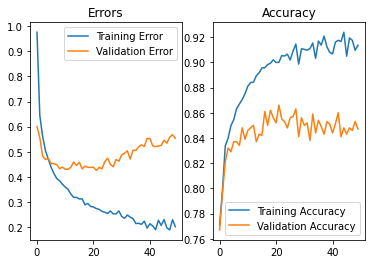

In [26]:
#@title Sigmoid Mini GD Large data{vertical-output:true}
model = Classification(_no_of_class=10, 
                       _hidden_layer=[32, 32], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.TAN_H, 
                       _optimization_algorithm=OptimizationAlgorithm.MINI_BATCH,
                       _batch_size = 64,
                       _max_epoch=50)

model.init_weight_and_bias()

tr_err, val_err, tr_acc, val_acc = model.fit(x_train[:10000], y_train[:10000], x_validation[:1000], y_validation[:1000])
plot_graphs(tr_err, val_err, tr_acc, val_acc)


In [ ]:
#@title Sigmoid GD Small data{ vertical-output: true}
model1 = Classification(_no_of_class=10, 
                       _hidden_layer=[64, 64], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.GD,
                       _max_epoch=400)
model1.init_weight_and_bias()

model1.fit(x_train[:10], y_train[:10])

In [ ]:
#@title Sigmoid Momentum Whole data{vertical-output:true}
model3 = Classification(_no_of_class=10, 
                       _hidden_layer=[32, 32], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.MOMENTUM_GD,
                       _batch_size = 50,
                       _momentum = 0.9,
                       _max_epoch=80)

model3.init_weight_and_bias()

model3.fit(x_train, y_train)


In [ ]:
#@title Sigmoid NAG Whole data{vertical-output:true}
model4 = Classification(_no_of_class=10, 
                       _hidden_layer=[32, 32], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.NAG,
                       _batch_size = 50,
                       _momentum = 0.9,
                       _max_epoch=80)

model4.init_weight_and_bias()

model4.fit(x_train, y_train)

In [ ]:
#@title Sigmoid SGD whole data{ vertical-output: true}
model5 = Classification(_no_of_class=10, 
                       _hidden_layer=[64, 64], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.SGD,
                       _max_epoch=10)
model5.init_weight_and_bias()

model5.fit(x_train, y_train)

In [ ]:
#@title Sigmoid RMS whole data{ vertical-output: true}
model6 = Classification(_no_of_class=10, 
                       _hidden_layer=[32, 32], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.1,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.RMS_PROP,
                       _batch_size = 100,
                       _momentum = 0.9,
                       _max_epoch=10)
model6.init_weight_and_bias()

model6.fit(x_train, y_train)